VAEと同様に教科書の指定をしている Francois Chollet さんの
「Deep Learning with Python」
(邦訳「PythonとKerasによるディープラーニング」)のコードを元に作成しています

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb

本ノートブックでは実際には使っていないコードもオプションの１つとしてコメントアウトして掲載してある。これはGANの学習にはいくつものヒューリスティックスがあり、データセットやネットワークの構造に依存して取捨選択する必要があるためである。つまり、今回の問題設定でうまくいかなかったとしても他の問題設定ではうまくいく可能性が十分にある。

In [0]:
import keras
from keras import layers
import numpy as np

latent_dim = 100
height = 28
width = 28
channels = 1

#最適化アルゴリズム
#学習を安定させるために重みをclip＆weight decayを用いる
#識別者の学習ではRMSpropを用いたほうが良いとする事例もある
#またlrを非常に小さくする(0.00005以下)場合もある
#rmsp = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
#識別者用＆敵対者用(DCGAN論文では両方Adam)
adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0, decay=1e-8)

#DCGAN論文ではすべての重みを以下で初期化している
init = keras.initializers.RandomNormal(stddev=0.02)


Using TensorFlow backend.


In [0]:
#生成ネットワーク
generator_input = keras.Input(shape=(latent_dim,))

#潜在変数を7x7 128-channels 特徴マップへ変換
x = layers.Dense(128 * 7 * 7,kernel_initializer=init)(generator_input)
#この実装では生成ネットワークの活性化関数にLeakyReLUを用いるが
#代わりに以下のBatchNormalization＋LeRUを使う場合もある
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Reshape((7, 7, 128))(x)

#7x7 128-channelsを14x14 64-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)

#14x14 64-channelsを28x28 64-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)


#28x28 64-channelsを28x28 1-channelsの特徴マップへ変換
#最後の出力の活性化関数はtanhを使う
x = layers.Conv2D(channels, 5, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

W0701 00:43:23.580001 140411466381184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 00:43:23.581536 140411466381184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 00:43:23.586215 140411466381184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0701 00:43:23.609739 140411466381184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        131136    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        65600     
__________

In [0]:
#識別ネットワーク
#LeakyReLU、Dropout、GlobalAveragedPoolingを使うのがポイント
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(64, 5, strides=2,padding='same',kernel_initializer=init)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()


discriminator_optimizer  = adam
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

W0701 00:43:28.713172 140411466381184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0701 00:43:28.722357 140411466381184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0701 00:43:28.820432 140411466381184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0701 00:43:28.834246 140411466381184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_im

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
__________

In [0]:
#敵対的な生成ネットワークの学習

#識別ネットワークの学習を止めて
discriminator.trainable = False
#生成ネットワークの学習をする
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = adam 
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [0]:
import os
from keras.preprocessing import image
from keras.datasets import mnist
from tqdm import tqdm

# MNIST dataのロード
(x_train, _), (x_test, y_test) = mnist.load_data()


#各ピクセルが[0,1]の値を取るように正規化
#x_train = x_train.astype('float32') / 255.
#x_train = x_train.reshape(x_train.shape + (1,))
#x_test = x_test.astype('float32') / 255.
#x_test = x_test.reshape(x_test.shape + (1,))

#生成者の出力をtanhとしたので
#各ピクセルが[-1,1]の値を取るように正規化
x_train = (x_train.astype('float32')-127.5)/ 127.5
x_train = x_train.reshape(x_train.shape + (1,))
x_test = (x_test.astype('float32')-127.5)/ 127.5
x_test = x_test.reshape(x_test.shape + (1,))

#DCGAN論文で使われているバッチ数を使う
batch_size = 128


epochs=20
batchSize=batch_size
batchCount = x_train.shape[0] / batchSize
print ('Epochs:', epochs)
print ('Batch size:', batchSize)
print ('Batches per epoch:', batchCount)

# 学習のループ
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15) 
    #tqdmを使うとプログレスバーが出るがColabだと不安定なので別で代用する
    #for _ in tqdm(range(int(batchCount))): 
    for i in range(int(batchCount)):
        print("\r{0}% [{1}]".format(int(i/(batchCount-1)*100), "*" * int((i+1)/batchCount*50)), end="")
        # 潜在空間からランダムにサンプリング
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # データを生成する
        generated_images = generator.predict(random_latent_vectors)

        # 観測データと生成データを識別するための入力データをつくる
        real_images = x_train[np.random.randint(0, x_train.shape[0], size=batchSize)]
        combined_images = np.concatenate([generated_images, real_images])

        # 観測データ(1)と生成データ(0)を識別するラベルをつくる
        labels = np.concatenate([np.zeros((batch_size, 1)),
                             np.ones((batch_size, 1))])
        
        # ランダムなノイズを加える
        # ラベルを1ではなく0.7-1.2, 0を0-0.3のようなソフトラベルにすることもある
        #labels += 0.05 * np.random.random(labels.shape)
        labels *= 0.9


        #識別ネットワークの学習
        d_loss = discriminator.train_on_batch(combined_images, labels)

        #潜在空間からサンプリング
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # すべてリアルなデータだと騙すためのラベル(y=1)を生成
        misleading_targets = np.ones((batch_size, 1))

        # 生成ネットワークの学習
        # min -log(D(G(z)))
        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
        if i==int(batchCount)-1 :
            print("\n") 
            print('discriminator loss: %s' % (d_loss))
            print('adversarial loss  : %s' % (a_loss))
        
      

Epochs: 20
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------
0% []

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


99% [*************************************************]

discriminator loss: 0.6860328
adversarial loss  : 0.7751118
--------------- Epoch 2 ---------------
99% [*************************************************]

discriminator loss: 0.6880536
adversarial loss  : 0.8086026
--------------- Epoch 3 ---------------
99% [*************************************************]

discriminator loss: 0.6695062
adversarial loss  : 0.8755352
--------------- Epoch 4 ---------------
99% [*************************************************]

discriminator loss: 0.6585274
adversarial loss  : 0.86256236
--------------- Epoch 5 ---------------
99% [*************************************************]

discriminator loss: 0.69703317
adversarial loss  : 0.76563686
--------------- Epoch 6 ---------------
99% [*************************************************]

discriminator loss: 0.6639415
adversarial loss  : 0.8085966
--------------- Epoch 7 ---------------
99% [*************************************************]

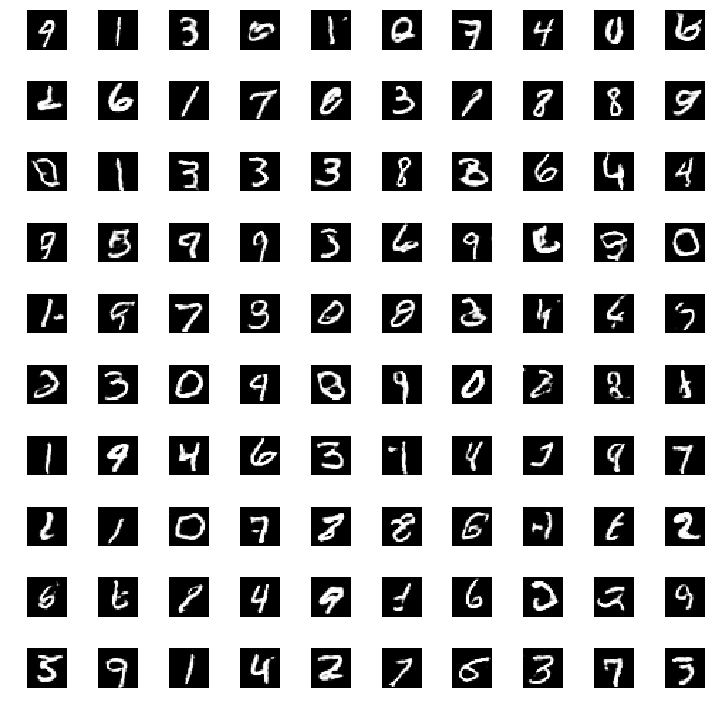

In [0]:
import matplotlib.pyplot as plt
#表示するサンプル数
examples=100
#潜在空間からサンプリング
noise = np.random.normal(0, 1, size=[examples, latent_dim])
#画像を生成
generatedImages = generator.predict(noise)
#画像を描画
dim=(10, 10)
plt.figure(figsize=(10, 10))
for i in range(generatedImages.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generatedImages[i].reshape(height, width), interpolation='nearest', cmap='gray')
    plt.axis('off')
plt.tight_layout()
#plt.savefig('./dcgan_generated_image_epoch_%d.png' % epoch)